# Feature engineering
#### We want to find some new features about the quality of Mobile network and determine whether the new features are suitable.  
feature 1: distance_velocity  
feature 2: ratio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_loader_sortvalue
import math
import folium
import webbrowser as web
from folium.plugins import HeatMap
import seaborn as sns
import warnings
import sklearn.preprocessing as preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
warnings.filterwarnings('ignore')

### feature 1: distance_velocity  
Determine the speed or distance of this line based on the 'movement_state' of the previous data.

In [3]:
dtype = {'wagon_ID': str,
         'timestamp_measure_position': str,
         'latitude': float,
         'longitude': float,
         'up_movement_state': str,  # The 'movement_state' of the previous row
         'distance': float,
         'velocity': float,
         'time':float}
use_cols = ['latitude',
            'longitude',
            'wagon_ID',
            'timestamp_measure_position',
            'distance',
            'velocity',
            'up_movement_state',
            'time']

In [4]:
wagon_info = pd.read_csv('../../../data/Task2_celluar/result_01.csv', dtype=dtype, usecols=use_cols)
print('loading_finish')

loading_finish


**'up_movement_state'** indicates the movement_state of the previous line. When the movement_state is **moving**, we observe the velocity between the two rows. When the movemen_tstate is **standing** or **parking**, we observe the distance. The velocity should bigger than 0 and smaller than 120km/h. The distance should be close to 0.

In [5]:
# Extract the data in the previous row where movement_state is 0 or 1
wagon_info['up_movement_state'] = wagon_info['up_movement_state'].dropna().astype(np.float16).astype(np.int8)
wagon_info_distance = wagon_info.loc[(wagon_info['up_movement_state'] == 0) | (wagon_info['up_movement_state'] == 1)]
wagon_info_distance.loc[wagon_info_distance['distance'] > 10, 'distance'] = 10
wagon_info_distance.loc[:, 'velocity'] = 0

# Extract the data in the previous row where movement_state is 2
wagon_info_velocity = wagon_info.loc[wagon_info['up_movement_state'] == 2]
wagon_info_velocity.loc[wagon_info_velocity['velocity'] > 120, 'velocity'] = 120
wagon_info_velocity.loc[:, 'distance'] = 0

<AxesSubplot:xlabel='distance', ylabel='Density'>

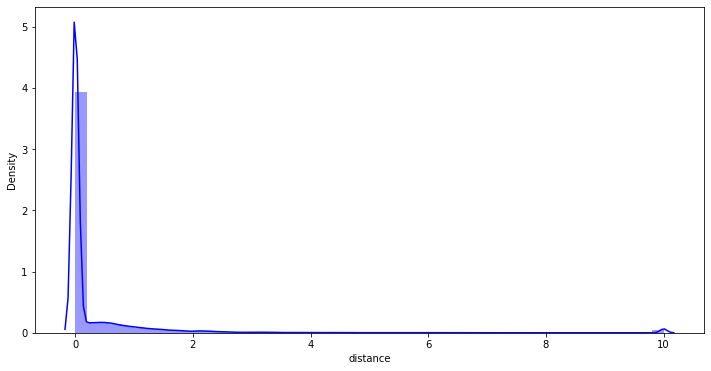

In [6]:
# Density frequency histogram about distance
plt.figure(figsize=(12, 6))
sns.distplot(wagon_info_distance['distance'], norm_hist=False, color="b", label="distance")

When wagon is stationary, the distance is mostly 1 km or less.

<AxesSubplot:xlabel='velocity', ylabel='Density'>

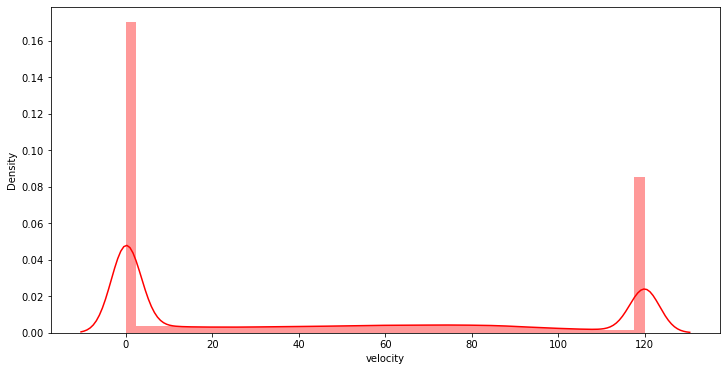

In [7]:
# Density frequency histogram about velocity
plt.figure(figsize=(12, 6))
sns.distplot(wagon_info_velocity['velocity'], norm_hist=False, color="r", label="velocity")

More than half of the velocity is 0 or greater than 120 during the movement, which is not possible.

In [8]:
wagon_info_distance.describe()

,latitude,longitude,up_movement_state,time,distance,velocity
count,4.120762e+06,4.120762e+06,4.120762e+06,4.120762e+06,4.120762e+06,4120762.0
mean,5.081506e+01,9.330484e+00,8.922622e-02,8.135003e-01,3.539465e-01,0.0
std,2.299593e+00,2.952178e+00,2.850700e-01,9.588013e-01,1.206475e+00,0.0
min,3.803515e+01,-2.213348e+00,0.000000e+00,3.055556e-06,0.000000e+00,0.0
25%,4.946059e+01,7.167030e+00,0.000000e+00,2.658333e-01,0.000000e+00,0.0
50%,5.136495e+01,8.568300e+00,0.000000e+00,1.066667e+00,0.000000e+00,0.0
75%,5.166383e+01,1.108817e+01,0.000000e+00,1.066667e+00,2.342199e-02,0.0
max,6.780103e+01,2.865417e+01,1.000000e+00,7.205000e+01,1.000000e+01,0.0


In [9]:
# Consider anything larger than 1km as an outlier and assign a value of 1km.
wagon_info_distance.loc[wagon_info_distance['distance'] > 1, 'distance'] = 1

The next step is to use a one-dimensional clustering of this feature to analyze the distribution of this feature. Determine the optimal number of classifications using the elbow function

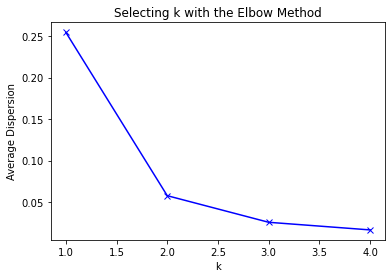

In [10]:
Y = wagon_info_distance['distance']
X = Y.values.reshape(-1,1)
K = range(1, 5)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

The elbow function shows that the data are most reasonably divided into two categories. 

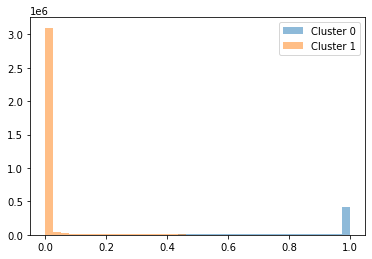

In [11]:
cluster_id = KMeans(2).fit_predict(X.reshape(-1, 1))

fig, ax = plt.subplots()
bins = np.linspace(X.min(), X.max(), 40)
for ii in np.unique(cluster_id):
    subset = X[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
plt.show()

In [12]:
print(X[cluster_id==0].min(), X[cluster_id==1].min())

0.4420415680453969 0.0


Reassign a value to distance, the closer the distance is to 0, the better the measured position is.

In [13]:
wagon_info_distance.loc[wagon_info_distance['distance'] <= 0.44,'distance'] = 0.1
wagon_info_distance.loc[wagon_info_distance['distance'] > 0.44,'distance'] = 0
wagon_info_distance['distance'] = 10 * wagon_info_distance['distance']

Analyze the velocity in the same way.

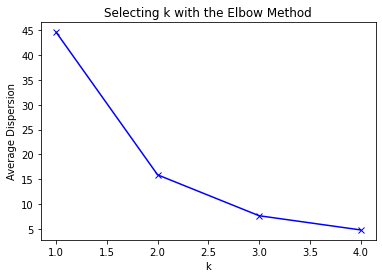

In [14]:
Y = wagon_info_velocity['velocity']
X = Y.values.reshape(-1,1)
K = range(1, 5)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

Although the elbow function shows that the data are most reasonably divided into two categories. However, based on the frequency distribution histogram, we would like to divide velocity into four categories. Based on the clustering results, the velocity is reassigned, and those close to 120 and 0km/h are assigned a value of 0.

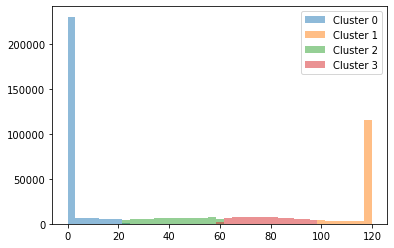

In [15]:
cluster_id = KMeans(4).fit_predict(X.reshape(-1, 1))

fig, ax = plt.subplots()
bins = np.linspace(X.min(), X.max(), 40)
for ii in np.unique(cluster_id):
    subset = X[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
plt.show()

In [16]:
wagon_info_velocity.loc[wagon_info_velocity['velocity'] < 3,'velocity'] = 0
wagon_info_velocity.loc[wagon_info_velocity['velocity'] == 120,'velocity'] = 0
wagon_info_velocity.loc[(wagon_info_velocity['velocity'] <= 20) & (wagon_info_velocity['velocity']>3),'velocity'] = 0.5
wagon_info_velocity.loc[(wagon_info_velocity['velocity'] > 100) & (wagon_info_velocity['velocity']<120),'velocity'] = 0.5
wagon_info_velocity.loc[(wagon_info_velocity['velocity'] > 20) & (wagon_info_velocity['velocity'] <= 100),'velocity'] = 1

Combining the speed and distance features into 'velocity_distance_Normalization', **1** indicates good network quality and **0** indicates bad.

In [17]:
pd_new = pd.concat([wagon_info_velocity, wagon_info_distance], axis=0)
pd_new['distance_Normalization'] = pd_new['distance'].fillna('0').astype(np.float32)
pd_new['velocity_Normalization'] = pd_new['velocity'].fillna('0').astype(np.float32)
pd_new['velocity_distance_Normalization'] = pd_new['velocity'] + pd_new['distance']
pd_new

,wagon_ID,latitude,longitude,up_movement_state,timestamp_measure_position,time,distance,velocity,distance_Normalization,velocity_Normalization,velocity_distance_Normalization
3,'1009283287612899',50.203655,7.592347,2.0,5 days 10:06:25,0.180278,0.0,1.0,0.0,1.0,1.0
4,'1009283287612899',50.130585,7.736540,2.0,5 days 10:17:02,0.176944,0.0,1.0,0.0,1.0,1.0
6,'1009283287612899',47.293739,5.036352,2.0,8 days 04:07:02,0.179722,0.0,1.0,0.0,1.0,1.0
13,'1017603200023941',49.370914,8.066085,2.0,9 days 10:25:19,0.180556,0.0,1.0,0.0,1.0,1.0
14,'1017603200033940',53.525555,9.990044,2.0,5 days 22:34:31,0.029722,0.0,0.5,0.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...
4947732,'889603219874371',49.440697,8.559687,0.0,5 days 00:44:18,14.484167,0.0,0.0,0.0,0.0,0.0
4947733,'889603220014371',49.462383,8.512672,0.0,5 days 08:57:52,8.327222,0.0,0.0,0.0,0.0,0.0
4947734,'889603220014371',52.390465,9.625400,0.0,7 days 17:37:46,22.603056,0.0,0.0,0.0,0.0,0.0
4947735,'889603220014371',52.391792,9.639581,0.0,8 days 05:00:08,10.848889,1.0,0.0,1.0,0.0,1.0


In [18]:
# save csv
col_list = ['wagon_ID', 'latitude', 'longitude', 'timestamp_measure_position', 'velocity_distance_Normalization']
pd_new = pd_new.loc[:,col_list].reset_index(drop=True)
pd_new.to_csv('../../../data/Task2_celluar/feature_sv.csv',index=False)

### feature 2: ratio
Ratio here is an abstract concept. We count all points in the 0.1km range and in the 1km range of each point. Then we divide the value corresponding to 1km by the value corresponding to 0.1km. We call this value ratio. If ratio is too big, we can consider that the density of points within 0.1km of this point is significantly smaller than elsewhere. If ratio is too small, we can consider that the points within 1km of this point is not too much. Both situations indicate bad network quality.   

In [19]:
dtype={'wagon_ID': str,
       'loading_state': str,
       'loading_state_update': str,
       'altitude': np.float16,
       'latitude': np.float32,
       'longitude': np.float32,
       'signal_quality_satellite': np.float32,
       'signal_quality_hdop': np.float32,
       'determination_position': np.uint8,
       'GNSS_velocity': np.float16,
       'timestamp_measure_position': str,
       'timestamp_transfer': str,
       'movement_state': str,
       'timestamp_measure_movement_state': str,
       'timestamp_index': str,
       'provider': np.uint8}

use_cols=['wagon_ID',
          'latitude',
          'longitude',
          'timestamp_measure_position',
          'determination_position']

# read csv
df = pd.read_csv("../../../data/raw/01_211203_TUDA_data.csv",usecols=use_cols,dtype=dtype)


In [20]:
# Define a function. The function will retain the n-digit decimal part. For example, round_down(45.777,1) = 45.7,
# round_down(45.777, 2) = 45.77
def round_down(m,n):
    a = math.floor(m*10**n)/(10**n)
    return a  

In [21]:
# Use the above function for latitude and longitude
df['la_1']=df.latitude.apply(lambda x: round_down(x,1))
df['lo_1']=df.longitude.apply(lambda x: round_down(x,1))
df['la_01']=df.latitude.apply(lambda x: round_down(x,2))
df['lo_01']=df.longitude.apply(lambda x: round_down(x,2))

In [22]:
# Count how many values are the same in total
df['ratio_01']=df.groupby(['la_01','lo_01'],as_index=False)['la_01'].transform('count')
df['ratio_1']=df.groupby(['la_1','lo_1'],as_index=False)['la_01'].transform('count')

In [23]:
# ratio_1/ratio_01 indicates ratio_x. For example, when lat = 45.777, la_01 will equal 45.77 and la_1 equal 45.7. 
# For lat 45.777, ratio_1 indicates how many points in the range of 45.7-45.8. 
# ratio_01 indicates how many points in the range of 45.77-45.78.
df['ratio_x']=df['ratio_1']/df['ratio_01']
df.tail()

,wagon_ID,latitude,longitude,determination_position,timestamp_measure_position,la_1,lo_1,la_01,lo_01,ratio_01,ratio_1,ratio_x
12176691,'1017603230354522',51.704350,6.979754,1,3 days 11:11:24,51.7,6.9,51.70,6.97,63,116,1.841270
12176692,'1017603248383943',50.944016,7.020907,1,2 days 23:40:57,50.9,7.0,50.94,7.02,6,191566,31927.666667
12176693,'697603222334427',52.248024,10.545093,1,3 days 14:49:47,52.2,10.5,52.24,10.54,10737,79125,7.369377
12176694,'697603213104425',53.394966,10.054642,4,3 days 05:49:31,53.3,10.0,53.39,10.05,2295,60398,26.317211
12176695,'697603212906457',49.418098,11.105467,1,3 days 19:18:45,49.4,11.1,49.41,11.10,6590,49988,7.585432


In [24]:
df['ratio_x'].describe()

count    1.217670e+07
mean     3.533224e+01
std      6.668789e+02
min      1.000000e+00
25%      2.877946e+00
50%      5.836834e+00
75%      1.401774e+01
max      3.618740e+05
Name: ratio_x, dtype: float64

<AxesSubplot:xlabel='ratio_x_new', ylabel='Density'>

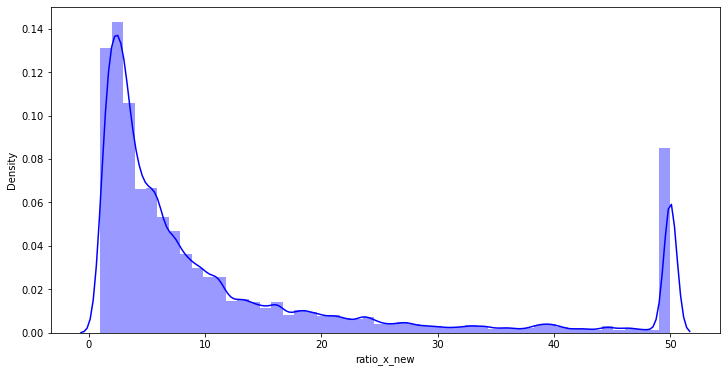

In [25]:
# All values greater than 50 are assigned to 50
df['ratio_x_new'] = df['ratio_x']
df.loc[df['ratio_x_new']>=50,'ratio_x_new'] = 50
plt.figure(figsize=(12, 6))
sns.distplot(df['ratio_x_new'], norm_hist=False, color="b", label="ratio_x")

In [26]:
# All values greater than 50 are assigned to 50
df['ratio_x_new'] = df['ratio_x']
df.loc[df['ratio_x_new']>=50,'ratio_x_new'] = 50

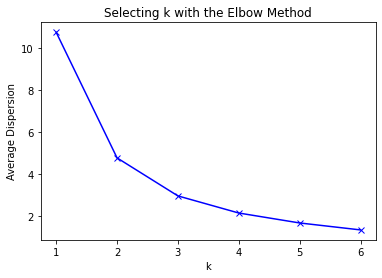

In [27]:
# Elbow function for 1D dclustering
Y = df['ratio_x_new']
X = Y.values.reshape(-1,1)
K = range(1, 7)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

Although the elbow function shows that the data are most reasonably divided into two categories. However, based on the frequency distribution histogram, we would like to divide velocity into five categories.

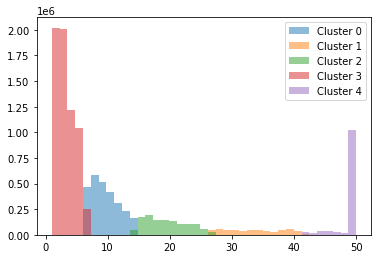

In [28]:
# 1D clustering
X = Y.values.reshape(-1,1)
cluster_id = KMeans(5).fit_predict(X.reshape(-1, 1))

fig, ax = plt.subplots()
bins = np.linspace(X.min(), X.max(), 40)
for ii in np.unique(cluster_id):
    subset = X[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
plt.show()

In [29]:
print(X[cluster_id==0].min(),X[cluster_id==1].min(),X[cluster_id==2].min(),X[cluster_id==3].min(),X[cluster_id==4].min())

6.376642335766423 26.583333333333332 14.48984771573604 1.0 41.48936170212766


In [30]:
# Assign values to different classes, 1 is the best network quality
df.loc[df['ratio_x_new'] <= 6.34, 'ratio_x_new'] = 0
df.loc[df['ratio_x_new'] > 41.27, 'ratio_x_new'] = 0
df.loc[(df['ratio_x_new'] <= 14.34) & (df['ratio_x_new'] > 6.34), 'ratio_x_new'] = 1
df.loc[(df['ratio_x_new'] > 14.34) & (df['ratio_x_new'] < 41.27), 'ratio_x_new'] = 0.5

In [31]:
df_writedown = df[df['determination_position'] == 4]
df_writedown = df_writedown[['wagon_ID', 'latitude', 'longitude', 'timestamp_measure_position', 'ratio_x_new' ]]

In [32]:
df_writedown.to_csv('../../../data/Task2_celluar/ratio01.csv', index=False)

### feature3: time gap

As already mentioned, the feature timegap does not carry too much information. The next step is to use a one-dimensional clustering of this feature to analyze the distribution of this feature.

In [33]:
dtype = {'wagon_ID': str,
         'timestamp_measure_position': str,
         'timestamp_transfer': str,
         'determination_position': int,
         'timestamp_index': str,
         'latitude': float,
         'longitude': float}

use_cols = ['determination_position',
            'wagon_ID',
            'timestamp_measure_position',
            'timestamp_transfer',
            'timestamp_index',
            'latitude',
            'longitude',
            'movement_state',
            'provider']

In [34]:
# read files with the defined function
wagon_info = data_loader_sortvalue.load_raw_csv(1,use_cols)
print('Loading_finish')

Loading finished 1/4
movement_state DONE 2/4
concat DONE 3/4
timestamp_index DONE 4/4
Loading_finish


In [35]:
# Extracting data
wagon_info = wagon_info[wagon_info['determination_position'] == 4]

In [36]:
# preprocessing
wagon_info['timestamp_measure_position'] = wagon_info['timestamp_measure_position'].dropna()
wagon_info['timestamp_transfer'] = wagon_info['timestamp_transfer'].dropna()
wagon_info['timestamp_index'] = wagon_info['timestamp_index'].dropna()
wagon_info['timestamp_measure_position'] = pd.to_timedelta(wagon_info['timestamp_measure_position'])
wagon_info['timestamp_transfer'] = pd.to_timedelta(wagon_info['timestamp_transfer'])
wagon_info['timestamp_index'] = pd.to_timedelta(wagon_info['timestamp_index'])

In [37]:
# time_gap is the difference between 'timestamp_transfer' and 'timestamp_measure_position'
wagon_info['time_gap'] = (wagon_info['timestamp_transfer'] - wagon_info['timestamp_measure_position']).apply(lambda x: x.total_seconds() / 3600)

In [38]:
wagon_info.describe()

,latitude,longitude,determination_position,timestamp_measure_position,timestamp_transfer,movement_state,timestamp_index,provider,time_gap
count,4.947738e+06,4.947738e+06,4947738.0,4947738,4947738,4.947738e+06,4947738,4.947738e+06,4.947738e+06
mean,4.936868e+01,9.391858e+00,4.0,6 days 09:35:35.977249078,6 days 15:50:15.520763762,4.954349e-01,6 days 15:50:23.602550296,3.683680e+01,6.244318e+00
std,2.717169e+00,2.963025e+00,0.0,1 days 23:34:22.807144737,2 days 00:07:34.338620302,9.085323e-01,2 days 00:07:34.114038086,8.884622e-01,7.490625e+00
min,3.803515e+01,-4.120857e+00,4.0,2 days 23:00:00,2 days 23:00:02.991000,0.000000e+00,2 days 23:00:06,3.200000e+01,0.000000e+00
25%,4.945983e+01,7.167376e+00,4.0,4 days 16:30:06,4 days 22:45:07.524000,0.000000e+00,4 days 22:45:10,3.700000e+01,5.734167e-01
50%,5.136495e+01,8.654176e+00,4.0,6 days 09:29:01,6 days 14:49:08.989000,0.000000e+00,6 days 14:49:13,3.700000e+01,3.964429e+00
75%,5.167260e+01,1.108489e+01,4.0,8 days 01:52:44,8 days 08:13:14.002000,1.000000e+00,8 days 08:13:20,3.700000e+01,9.846241e+00
max,6.780103e+01,2.865417e+01,4.0,9 days 22:59:59,10 days 10:00:28.555000,3.000000e+00,10 days 10:00:31,3.700000e+01,1.776100e+02


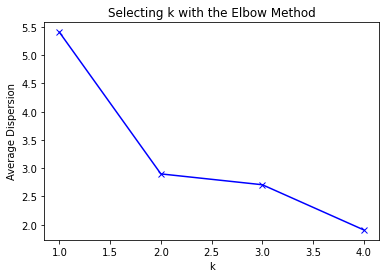

In [39]:
# Determine the optimal number of classifications using the elbow function
Y = wagon_info['time_gap']
X = Y.values.reshape(-1,1)
K = range(1, 5)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Dispersion')
plt.title('Selecting k with the Elbow Method')
plt.show()

Although the elbow function shows that the data are most reasonably divided into two categories. However, based on the frequency distribution histogram, we would like to divide time_gap into three categories. The shorter the time_gap, the better we consider the network signal quality.

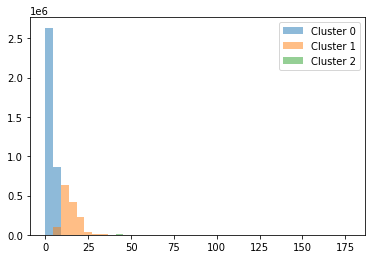

In [40]:
cluster_id = KMeans(3).fit_predict(X.reshape(-1, 1))

fig, ax = plt.subplots()
bins = np.linspace(X.min(), X.max(), 40)
for ii in np.unique(cluster_id):
    subset = X[cluster_id==ii]
    ax.hist(subset, bins=bins, alpha=0.5, label=f"Cluster {ii}")
ax.legend()
plt.show()

In [41]:
# Show the boundaries of the classification
print(X[cluster_id==0].min(),X[cluster_id==1].min(),X[cluster_id==2].min())

0.0 8.490100833333333 38.2355925


In [42]:
# Assign values to each of the three groups. 1 means the best and 0 means the worst.
wagon_info.loc[wagon_info['time_gap'] <= 8.47, 'time_gap'] = 1
wagon_info.loc[(wagon_info['time_gap'] <= 37.68) & (wagon_info['time_gap'] > 8.47), 'time_gap'] = 0.5
wagon_info.loc[wagon_info['time_gap'] > 37.68, 'time_gap'] = 0

In [43]:
# Save as csv
col_list = ['wagon_ID', 'latitude', 'longitude', 'timestamp_measure_position', 'time_gap']
pd_new = wagon_info.loc[:,col_list].reset_index(drop=True)
pd_new.to_csv('../../../data/Task2_celluar/feature_timegap.csv')